У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

### Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

**Завдання 1.** Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_df = pd.read_csv("customer_segmentation_train.csv")
raw_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4]:
raw_df[raw_df.select_dtypes(include='object').columns].nunique()

Gender            2
Ever_Married      2
Graduated         2
Profession        9
Spending_Score    3
Var_1             7
Segmentation      4
dtype: int64

In [5]:
raw_df.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


**ПРОАНАЛІЗУЄМО ПУСТІ ЗНАЧЕННЯ:**

In [6]:
missing_count = raw_df.isna().sum()
missing_percent = raw_df.isna().mean() * 100
missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percent": missing_percent
})
missing_df = missing_df[missing_df["missing_count"] > 0].sort_values(by="missing_percent", ascending=False)
missing_df["missing_percent"] = missing_df["missing_percent"].round(2)
missing_df

,missing_count,missing_percent
Work_Experience,829,10.28
Family_Size,335,4.15
Ever_Married,140,1.74
Profession,124,1.54
Graduated,78,0.97
Var_1,76,0.94


 - ***Work_Experience***
 
 Проаналізуємо цю колонку більш детально, адже вона має найбільшу частку пропущених даних

In [7]:
raw_df["Work_Experience"].describe()

count    7239.000000
mean        2.641663
std         3.406763
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        14.000000
Name: Work_Experience, dtype: float64

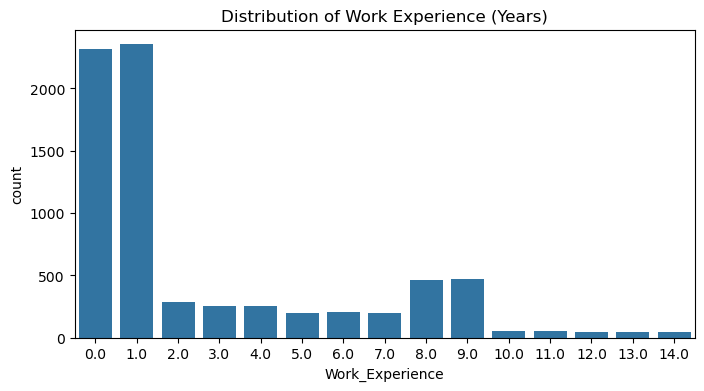

In [8]:
plt.figure(figsize=(8,4))
order = sorted(raw_df["Work_Experience"].dropna().unique())
sns.countplot(data=raw_df, x="Work_Experience", order=order)
plt.title("Distribution of Work Experience (Years)")
plt.show()

Подивимось частку пропусків Work_Experience в кожному сегменті:

In [9]:
raw_df.groupby("Segmentation")["Work_Experience"].apply(lambda x: x.isna().mean())

Segmentation
A    0.098377
B    0.103337
C    0.078680
D    0.126984
Name: Work_Experience, dtype: float64

Бачимо, що пропуски розподілені більш-менш рівномірно між сегментами.

Перевіримо ще, чи повʼязані пропуски з віком:

In [10]:
raw_df[raw_df["Work_Experience"].isna()]["Age"].describe()

count    829.000000
mean      43.494572
std       17.782069
min       18.000000
25%       30.000000
50%       39.000000
75%       53.000000
max       89.000000
Name: Age, dtype: float64

In [11]:
raw_df[raw_df["Work_Experience"].notna()]["Age"].describe()

count    7239.000000
mean       43.463738
std        16.586007
min        18.000000
25%        31.000000
50%        41.000000
75%        53.000000
max        89.000000
Name: Age, dtype: float64

Тобто, великої різниці в характеристиках віку в залежності від пропущених даних у Work_Experience ми не бачимо.

Подивимось ще, чи є якась залежність по професіям:

<Figure size 800x400 with 0 Axes>

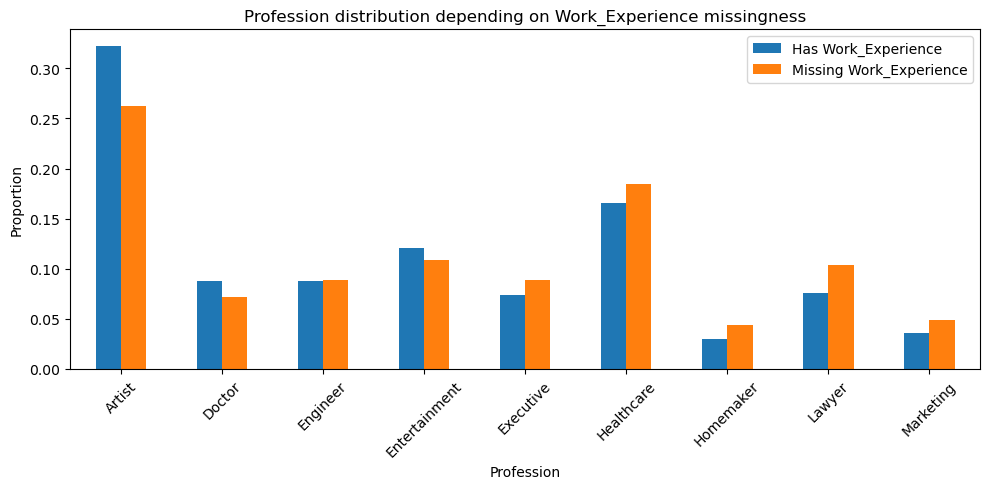

In [12]:
plt.figure(figsize=(8,4))
prof_plot = pd.crosstab(raw_df["Profession"], raw_df["Work_Experience"].isna(), normalize="columns")

prof_plot.plot(kind="bar", figsize=(10,5))
plt.title("Profession distribution depending on Work_Experience missingness")
plt.ylabel("Proportion")
plt.legend(labels=["Has Work_Experience", "Missing Work_Experience"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Хоч в деяких професіях ми бачимо невелику різницю в залежності пропущених значень у Work_Experience, та все ж ми не можемо сказати що ця залежність висока, спільний тренд родподілу по професіям зберігається.

Можемо зробити наступні висновки:
- Розподіл Work_Experience є асиметричним: більшість значень зосереджена біля 0–1 років, присутній правий хвіст до 14 років.
- Частка пропусків (~10%) розподілена більш-менш рівномірно між сегментами.
- Вік у спостереженнях з пропущеним Work_Experience статистично майже не відрізняється від віку у спостереженнях без пропусків.
- Також немає суттєвої залежності пропущених значень від Profession.

Через асиметричний розподіл і відсутність явної залежності пропусків від інших змінних, Work_Experience доцільно заповнювати медіаною.

In [13]:
raw_df["Work_Experience"] = raw_df["Work_Experience"].fillna(raw_df["Work_Experience"].median())

- ***Family_Size***

In [14]:
raw_df["Family_Size"].describe()

count    7733.000000
mean        2.850123
std         1.531413
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: Family_Size, dtype: float64

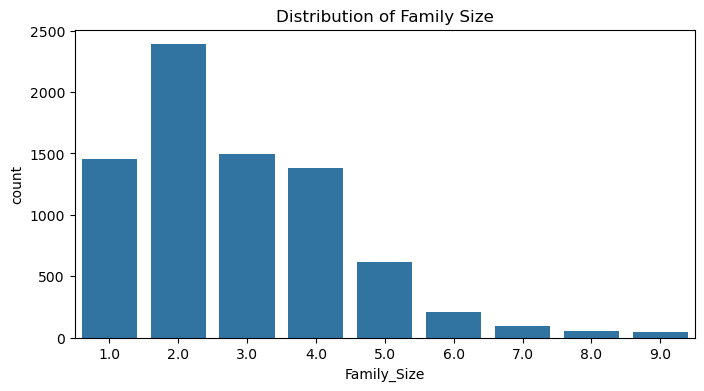

In [15]:
plt.figure(figsize=(8,4))
order = sorted(raw_df["Family_Size"].dropna().unique())
sns.countplot(data=raw_df, x="Family_Size", order=order)
plt.title("Distribution of Family Size")
plt.show()

In [16]:
raw_df.groupby("Segmentation")["Family_Size"].apply(lambda x: x.isna().mean())

Segmentation
A    0.048174
B    0.023143
C    0.022335
D    0.067460
Name: Family_Size, dtype: float64

Отже, Family_Size має невелику кількість пропусків, розподіл є правосторонньо скошеним, а пропуски розподілені відносно рівномірно між сегментами.    
Можемо теж заповнити медіаною:

In [17]:
raw_df["Family_Size"].fillna(raw_df["Family_Size"].median(), inplace=True)

- ***Ever_Married***

In [18]:
raw_df["Ever_Married"].value_counts(normalize=True)

Ever_Married
Yes    0.585646
No     0.414354
Name: proportion, dtype: float64

Значень Yes трохи більше, але цей перекос не дуже сильний.

In [19]:
raw_df.groupby("Ever_Married")["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Ever_Married,,,,,,,,
No,3285.0,32.237747,10.767210,18.0,25.0,30.0,38.0,89.0
Yes,4643.0,51.477278,15.541555,18.0,40.0,49.0,62.0,89.0


Тут бачимо, що середній вік неодружених (32 роки) значно менший ніж середній вік одружених (51 рік) Також відрізняється медіана (30 та 49 років відповідно). Тобто, ознака Ever_Married логічно повʼязана з віком.

In [20]:
raw_df[raw_df["Ever_Married"].isna()]["Age"].describe()

count    140.000000
mean      41.292857
std       16.578350
min       18.000000
25%       28.000000
50%       39.000000
75%       53.000000
max       89.000000
Name: Age, dtype: float64

In [21]:
raw_df["Age"].describe()

count    8068.000000
mean       43.466906
std        16.711696
min        18.000000
25%        30.000000
50%        40.000000
75%        53.000000
max        89.000000
Name: Age, dtype: float64

Тут бачимо, що пропуски не концентруються в якійсь віковій групі.

Заповнимо пропущені значення Yes або No в залежності від віку. Щоб знайти пороговий вік, після якого змінемо значення, зробимо наступне:

In [22]:
# Порахуємо частку Yes по кожному віку
age_marriage = pd.crosstab(raw_df["Age"], raw_df["Ever_Married"], normalize="index")
age_marriage.head()

Ever_Married,No,Yes
Age,,
18,0.968992,0.031008
19,0.968992,0.031008
20,0.975207,0.024793
21,0.973913,0.026087
22,0.946970,0.053030


In [23]:
# Знайдемо перший вік, де Yes > 0.5
threshold_age = age_marriage[age_marriage["Yes"] > 0.5].index.min()
threshold_age

np.int64(35)

In [24]:
# Тепер заповнюємо пропуски в залежності від віку
raw_df.loc[raw_df["Ever_Married"].isna() & (raw_df["Age"] >= threshold_age), "Ever_Married"] = "Yes"
raw_df.loc[raw_df["Ever_Married"].isna() & (raw_df["Age"] < threshold_age), "Ever_Married"] = "No"

- ***Profession***

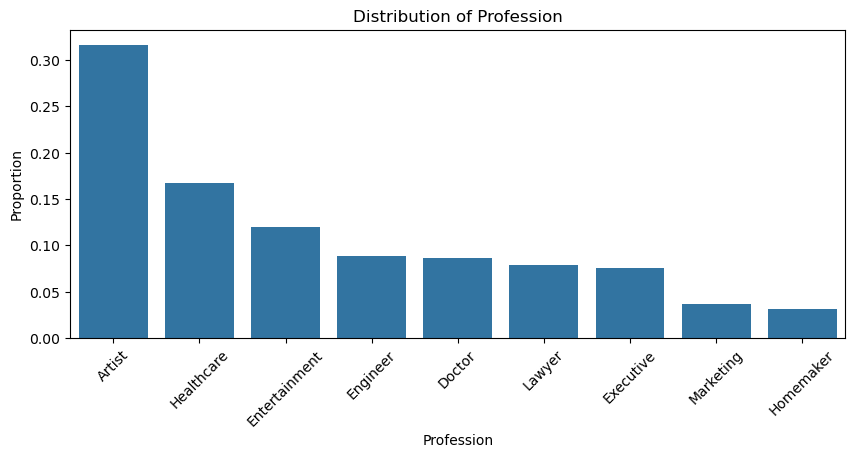

In [25]:
prof_dist = raw_df["Profession"].value_counts(normalize=True)

plt.figure(figsize=(10,4))
sns.barplot(x=prof_dist.index, y=prof_dist.values)
plt.xticks(rotation=45)
plt.ylabel("Proportion")
plt.title("Distribution of Profession")
plt.show()

In [26]:
raw_df.groupby("Segmentation")["Profession"].apply(lambda x: x.isna().mean())

Segmentation
A    0.016734
B    0.011841
C    0.009137
D    0.022487
Name: Profession, dtype: float64

Ознака Profession має невелику кількість пропусків і це категорільна колонка, тому з метою уникнення спотворення розподілу заповнимо пропуски окремою категорією “Unknown”.

In [27]:
raw_df["Profession"].fillna("Unknown", inplace=True)

- ***Graduated***

In [28]:
raw_df["Graduated"].value_counts(normalize=True)

Graduated
Yes    0.621777
No     0.378223
Name: proportion, dtype: float64

Враховуючи, що це бінарна категоріальна ознака, яка має небагато пропусків (<1%), то можемо заповнити пусті значення модою:

In [29]:
raw_df["Graduated"].fillna(raw_df["Graduated"].mode()[0], inplace=True)

- ***Var_1***

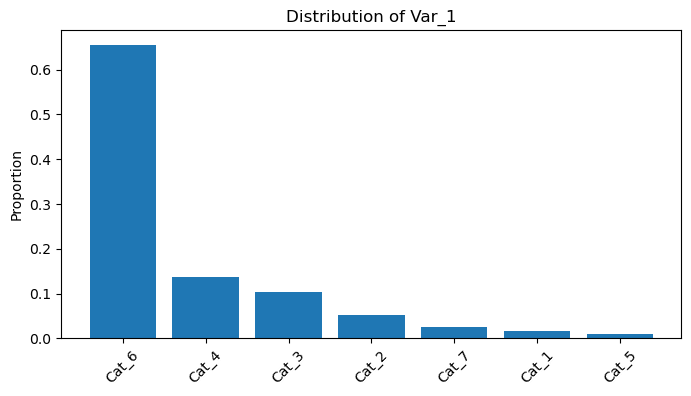

In [30]:
var_dist = raw_df["Var_1"].value_counts(normalize=True).sort_values(ascending=False)

plt.figure(figsize=(8,4))
plt.bar(var_dist.index, var_dist.values)
plt.ylabel("Proportion")
plt.title("Distribution of Var_1")
plt.xticks(rotation=45)
plt.show()

In [31]:
raw_df.groupby("Segmentation")["Var_1"].apply(lambda x: x.isna().mean())

Segmentation
A    0.009635
B    0.006997
C    0.010660
D    0.010141
Name: Var_1, dtype: float64

Пропуски по сегментаціям розподілені більш-менш однаково, самих пропущених значень маємо мало (<1%), а розподіл по категоріям сильно перекошений, бачимо чітко виражену моду. Тому нею і заповнимо пропущені значення.

In [32]:
raw_df["Var_1"].fillna(raw_df["Var_1"].mode()[0], inplace=True)

**КОДУВАННЯ КАТЕГОРІАЛЬНИХ ОЗНАК**

In [33]:
X = raw_df.drop(columns=["Segmentation", "ID"])
y = raw_df["Segmentation"]
X.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6


In [34]:
X["Gender"] = X["Gender"].map({"Male": 0, "Female": 1})
X["Ever_Married"] = X["Ever_Married"].map({"No": 0, "Yes": 1})
X["Graduated"] = X["Graduated"].map({"No": 0, "Yes": 1})

X["Spending_Score"] = X["Spending_Score"].map({"Low": 0, "Average": 1, "High": 2})

In [35]:
# Закодуємо ці категоріальні колонки за допомогою integer (label) encoding для коректної роботи SMOTENC
X["Profession"] = X["Profession"].astype("category").cat.codes
X["Var_1"] = X["Var_1"].astype("category").cat.codes

In [36]:
# Розділяємо дані на тренувальні та тестові
X_train, X_test, y_train, y_test = train_test_split( 
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
917,1,0,32,1,0,9.0,0,1.0,5
3398,0,1,72,1,3,1.0,1,2.0,5
2045,1,0,33,1,3,1.0,0,4.0,5
8060,1,1,48,1,0,0.0,1,6.0,5
4604,1,1,28,0,1,9.0,0,1.0,6
...,...,...,...,...,...,...,...,...,...
3822,1,0,27,0,6,8.0,0,1.0,5
5864,0,0,37,1,5,0.0,0,2.0,5
3589,1,0,27,0,2,6.0,0,6.0,3
1489,0,0,26,0,0,0.0,0,2.0,5


**Завдання 2. Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

In [37]:
binary_cols = ["Gender", "Ever_Married", "Graduated"]
ordinal_cols = ["Spending_Score"]
nominal_cols = ["Profession", "Var_1"]
numeric_cols = raw_df.select_dtypes(include='number').columns.drop('ID').to_list()

In [38]:
categorical_cols = binary_cols + ordinal_cols + nominal_cols
categorical_cols

['Gender',
 'Ever_Married',
 'Graduated',
 'Spending_Score',
 'Profession',
 'Var_1']

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", "passthrough", categorical_cols),
    ],
    remainder="drop"
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

cat_feature_indices = list(range(len(numeric_cols), len(numeric_cols) + len(categorical_cols)))
cat_feature_indices

smotenc = SMOTENC(
    categorical_features=cat_feature_indices,
    random_state=42
)
X_train_smotenc, y_train_smotenc = smotenc.fit_resample(X_train_proc, y_train)

# використаємо SMOTETomek з SMOTENC замість базового SMOTE, щоб правильно обробити категоріальні ознаки
smote_tomek_nc = SMOTETomek(
    smote=SMOTENC(categorical_features=cat_feature_indices, random_state=42),
    random_state=42
)
X_train_tomek_nc, y_train_tomek_nc = smote_tomek_nc.fit_resample(X_train_proc, y_train)

print("Original:", Counter(y_train))
print("SMOTENC:", Counter(y_train_smotenc))
print("SMOTE-Tomek (SMOTENC inside):", Counter(y_train_tomek_nc))

Original: Counter({'D': 1814, 'A': 1578, 'C': 1576, 'B': 1486})
SMOTENC: Counter({'A': 1814, 'B': 1814, 'C': 1814, 'D': 1814})
SMOTE-Tomek (SMOTENC inside): Counter({'D': 1494, 'C': 1481, 'B': 1416, 'A': 1411})


SMOTENC балансує класи шляхом генерації синтетичних прикладів з урахуванням категоріальних ознак.

SMOTE-Tomek додатково очищає межі між класами, видаляючи конфліктні зразки, тому розподіл може бути не ідеально рівним, але якість даних покращується.

**Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

In [40]:
nominal_idx = [len(numeric_cols) + categorical_cols.index(col) for col in nominal_cols]
ohe = ColumnTransformer(
    transformers=[
        ("nom", OneHotEncoder(handle_unknown="ignore", sparse_output=True), nominal_idx)
    ],
    remainder="passthrough"
)
ohe.fit(X_train_proc)

X_train_ohe = ohe.transform(X_train_proc)
X_train_smotenc_ohe = ohe.transform(X_train_smotenc)
X_train_tomek_ohe = ohe.transform(X_train_tomek_nc)
X_test_ohe = ohe.transform(X_test_proc)

model_orig = OneVsRestClassifier(LogisticRegression(max_iter=2000, random_state=42))
model_smotenc = OneVsRestClassifier(LogisticRegression(max_iter=2000, random_state=42))
model_tomek = OneVsRestClassifier(LogisticRegression(max_iter=2000, random_state=42))

model_orig.fit(X_train_ohe, y_train)
model_smotenc.fit(X_train_smotenc_ohe, y_train_smotenc)
model_tomek.fit(X_train_tomek_ohe, y_train_tomek_nc)

pred_orig = model_orig.predict(X_test_ohe)
pred_smotenc = model_smotenc.predict(X_test_ohe)
pred_tomek = model_tomek.predict(X_test_ohe)

In [41]:
print("ORIGINAL (no resampling):\n", classification_report(y_test, pred_orig))

ORIGINAL (no resampling):
               precision    recall  f1-score   support

           A       0.42      0.45      0.43       394
           B       0.41      0.15      0.22       372
           C       0.49      0.64      0.55       394
           D       0.64      0.76      0.69       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614



In [42]:
print("\nSMOTENC:\n", classification_report(y_test, pred_smotenc))


SMOTENC:
               precision    recall  f1-score   support

           A       0.42      0.47      0.44       394
           B       0.41      0.22      0.29       372
           C       0.50      0.61      0.55       394
           D       0.66      0.71      0.68       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



In [43]:
print("\nSMOTE-Tomek (SMOTENC inside):\n", classification_report(y_test, pred_tomek))


SMOTE-Tomek (SMOTENC inside):
               precision    recall  f1-score   support

           A       0.41      0.48      0.44       394
           B       0.42      0.20      0.27       372
           C       0.49      0.62      0.55       394
           D       0.67      0.71      0.69       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



In [44]:
f1_orig = f1_score(y_test, pred_orig, average="macro")
f1_smotenc = f1_score(y_test, pred_smotenc, average="macro")
f1_tomek = f1_score(y_test, pred_tomek, average="macro")

print("Metric used for comparison: macro F1\n")
print(f"macro F1 - ORIGINAL: {f1_orig:.4f}")
print(f"macro F1 - SMOTENC:  {f1_smotenc:.4f}")
print(f"macro F1 - TOMEK:    {f1_tomek:.4f}")

scores = {
    "ORIGINAL": f1_orig,
    "SMOTENC": f1_smotenc,
    "SMOTE-Tomek": f1_tomek
}
best_name = max(scores, key=scores.get)
print(f"\nBest model by macro F1: {best_name}")

Metric used for comparison: macro F1

macro F1 - ORIGINAL: 0.4750
macro F1 - SMOTENC:  0.4904
macro F1 - TOMEK:    0.4865

Best model by macro F1: SMOTENC


Ми спробували три варіанти:
- без балансування,
- з SMOTENC,
- з SMOTE-Tomek.

Покращення після балансування є, але воно невелике.

Для порівняння моделей було обрано macro F1 і порівнюючи цю метрику найкраще спрацювала модель, навчена на SMOTENC (0.4904 проти 0.4750 в original), однак різниця між моделями не є суттєвою.

Гіпотеза, чому немає суттєвої різниці між моделями - можливо через те, що початковий дисбаланс класів був не дуже сильним, а логістична регресія — проста лінійна модель, і додавання синтетичних прикладів не змінює кардинально межі між класами. SMOTENC покращив recall для слабших класів (як наприклад для класу B з 0.15 до 0.22), однак загальна структура даних, ймовірно, містить перекриття між сегментами, що обмежує потенційний приріст якості.

Тобто балансування трохи допомагає, але не вирішує проблему повністю.
Для суттєвого покращення, можливо, варто спробувати більш складні моделі.